# Task 1: PINNs for solving PDEs

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import pandas as pd
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

We consider the following PDE (corresponding to the evolution of the Temperature of the solid and liquid phase in the first cycle for the charging phase) governed by the following two equations $$\begin{aligned} \frac{\partial \bar{T}_{f}}{\partial t}+U_{f} \frac{\partial \bar{T}_{f}}{\partial x}=\alpha_{f} \frac{\partial^{2} \bar{T}_{f}}{\partial x^{2}}-h_{f}\left(\bar{T}_{f}-\bar{T}_{s}\right) & x \in[0,1], t \in[0,1] \\ \frac{\partial \bar{T}_{s}}{\partial t}=\alpha_{s} \frac{\partial^{2} \bar{T}_{s}}{\partial x^{2}}+h_{s}\left(\bar{T}_{f}-\bar{T}_{s}\right) & x \in[0,1], t \in[0,1]\end{aligned}$$ with initial conditions $$\bar{T}_{f}(x, t=0)=\bar{T}_{s}(x, t=0)=T_{0}, \quad x \in[0,1]$$


In [19]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5
        self.h_s = 6
        self.T_hot = 4
        self.T_0 = 1
        self.U_f = 1 

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    
    # Initial condition T_f(x,t = 0) = T_s(x,t=0) = T_0
    # def initial_condition(self, x):
    #     return torch.tensor(self.T_0)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        # t0 = self.domain_extrema[0, 0]
        # input_tb = self.soboleng.draw(self.n_tb)    # input_sb has two columns (t, x) both with random numbers in the two respective domains
        # input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)   # overwrite the entier column of time with t0
        # output_tb = torch.full(input_tb.shape, self.T_0)
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        # print("Input temporal boundary shape: ", input_tb.shape)
        # output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)
        output_tb = torch.randn(self.n_tb, 2).fill_(self.T_0)
        # print( "Output temporal boundary shape: ", output_tb.shape)
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        #! Should be fixed

        #set first column of output to be T_f
        #set second column of output to be T_s

        # Get x-coordinates of the extrema of the domain
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        # input_sb = self.convert(self.soboleng.draw(self.n_sb))
        input_sb = self.soboleng.draw(self.n_sb)

        # Corresponds to the dirichlet boundary condition u_b(t,-1) = 0
        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        # Corresponds to the dirichlet boundary condition u_b(t, 1) = 0
        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # These are the Dirichlet boundary conditions at the two extrema domain points -1 and 1
        # output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 2))
        # output_sb_0 = ((self.T_hot-self.T_0)/(1+torch.exp(-200*(input_sb-0.25)))+self.T_0) 

        input_sb_t =  input_sb[:, 0]
        
        output_sb_0 = ((self.T_hot-self.T_0)/(1+torch.exp(-200*(input_sb_t-0.25)))+self.T_0).reshape(-1,1)
        new_tensor = torch.zeros_like(output_sb_0)

        output_sb_0 = torch.cat((output_sb_0, new_tensor), dim=1)
        # print("Output sb: {}".format(output_sb_0))
        # output_sb_0 = torch.full(output_sb_0[:, 1].shape, 0)

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        # input_int = self.convert(self.soboleng.draw(self.n_int))
        input_int = self.soboleng.draw(self.n_int)
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    # Takes as input the temporal boundary points and returns the prediction of the neural network at the temporal boundary points
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        #print(u_pred_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    # Takes as input the spatial boundary points and returns the prediction of the neural network at the temporal boundary points
    def apply_boundary_conditions(self, input_sb):
        #! Error probably here
        input_sb.requires_grad = True

        #CORRECT
        input_sb_x0 = input_sb[:int(input_sb.shape[0]/2), :]
        input_sb_xL = input_sb[int(input_sb.shape[0]/2):, :]

        u_pred_Tf_x0 = self.approximate_solution(input_sb_x0)[:, 0]
        u_pred_Ts_x0 = self.approximate_solution(input_sb_x0)[:, 1]

        # print("T_f x0 pred: {}".format(u_pred_Tf_x0))


        grad_Ts_x0 = torch.autograd.grad(u_pred_Ts_x0.sum(), input_sb_x0, create_graph=True)[0][:, 1]

        # u_pred_xL = self.approximate_solution(input_sb_xL)
        u_pred_Tf_xL = self.approximate_solution(input_sb_xL)[:, 0]
        u_pred_Ts_xL = self.approximate_solution(input_sb_xL)[:, 1]

        grad_Tf_xL = torch.autograd.grad(u_pred_Tf_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]
        grad_Ts_xL = torch.autograd.grad(u_pred_Ts_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]

        u_pred_concat_1 = torch.cat((u_pred_Tf_x0.reshape(-1,1), grad_Ts_x0.reshape(-1,1)), dim =1)
        # print("U_pred_concat_1: ", u_pred_concat_1)
        u_pred_concat_2 = torch.cat((grad_Tf_xL.reshape(-1,1), grad_Ts_xL.reshape(-1,1)), dim =1)
        # print("U_pred_concat_2: ", u_pred_concat_2)
        total_concat = torch.cat((u_pred_concat_1, u_pred_concat_2), dim =0)
        # print("Total_concat: ", total_concat.shape)

        return torch.cat([u_pred_concat_1, u_pred_concat_2],0)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        #! Should be correct

        input_int.requires_grad = True

        # Obtain the prediction from the neural network
        u = self.approximate_solution(input_int)
        
        # First column of prediction will be the temperature of the fluid
        # Second column of prediction will be the temperature of the solid
        T_f = u[:,0]
        T_s = u[:,1]

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_tf = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_ts = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]
        
        grad_ts_t = grad_ts[:,0] 
        grad_ts_x = grad_ts[:,1]
        grad_tf_t = grad_tf[:,0]
        grad_tf_x = grad_tf[:,1 ]
        
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:,1]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:,1]


        residual1 = (grad_tf_t) + (self.U_f*grad_tf_x) - (self.alpha_f*grad_tf_xx) + (self.h_f*(T_f - T_s))
        residual2 = (grad_ts_t) - (self.alpha_s*grad_ts_xx) - self.h_s*(T_f - T_s)

        # print(residual1, residual2)

        # residual = residual1 + residual2
        # grad_u_t = grad_u[:, 0]
        # grad_u_x = grad_u[:, 1]
        # grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        #grad_u_sq_x = torch.autograd.grad(u_sq.sum(), input_int, create_graph=True)[0][:,1]

        # residual = grad_u_t - grad_u_xx
        return residual1.reshape(-1, ), residual2.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        # print(u_pred_sb.shape)


        # print("U_pred_sb: {}".format(u_pred_sb))
        # Seems correct
        # print("U_train_sb: {}".format(u_train_sb))

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        res1, res2 = self.compute_pde_residual(inp_train_int)
        # r_int = self.compute_pde_residual(inp_train_int)

        # Initial Condition loss
        res_tb = u_train_tb - u_pred_tb
        
        # This corresponds to the condition with the exponential in the boundary conditions
        ##########################################

        len_train_half = int(u_train_sb.shape[0]/2)
        # print("len_train: {}".format(len_train_half))
        #! ERROR?
        Tf_train_sb_0 = u_train_sb[:len_train_half, 0]
        Tf_pred_sb_0 = u_pred_sb[:len_train_half, 0]
        # print("Tf_train_sb_0: {}".format(Tf_train_sb_0))
        # print("Tf_pred_sb_0: {}".format(Tf_pred_sb_0))
        res_Tf_sb_0 = Tf_train_sb_0 - Tf_pred_sb_0

        # Condition grad T_s/x at x = 0
        Ts_train_sb_0 = u_train_sb[:len_train_half, 1]
        Ts_pred_sb_0 = u_pred_sb[:len_train_half, 1]
        # print("Ts_train_sb_0: {}".format(Ts_train_sb_0))
        # print("Ts_pred_sb_0: {}".format(Ts_pred_sb_0))
        res_Ts_sb_0 = Ts_train_sb_0 - Ts_pred_sb_0

        # Condition grad T_s/x at x = 1
        Ts_train_sb_L = u_train_sb[len_train_half:, 1]
        Ts_pred_sb_L = u_pred_sb[len_train_half:, 1]
        # print("Ts_train_sb_L: {}".format(Ts_train_sb_L))
        # print("Ts_pred_sb_L: {}".format(Ts_pred_sb_L))
        res_Ts_sb_L = Ts_train_sb_L - Ts_pred_sb_L

        # Condition grad T_f/x at x = 1
        Tf_train_sb_L = u_train_sb[len_train_half:, 0]
        Tf_pred_sb_L = u_pred_sb[len_train_half:, 0]
        # print("Tf_train_sb_L: {}".format(Tf_train_sb_L))
        # print("Tf_pred_sb_L: {}".format(Tf_pred_sb_L))
        res_Tf_sb_L = Tf_train_sb_L - Tf_pred_sb_L

        # print(res_Tf_sb_0)
        # print(res_Ts_sb_0)
        # print(res_Ts_sb_L)
        # print(res_Tf_sb_L)
        ############################``

        loss_sb = torch.mean(abs(res_Tf_sb_0) ** 2) + torch.mean(abs(res_Ts_sb_0) ** 2) + torch.mean(abs(res_Ts_sb_L) ** 2) + torch.mean(abs(res_Tf_sb_L) ** 2)
        loss_tb = torch.mean(abs(res_tb) ** 2)
        loss_int = torch.mean(abs(res1) ** 2) + torch.mean(abs(res2) ** 2)

        # print("Loss int: {}".format(loss_int))
        # print("Loss sb: {}".format(loss_sb))
        # print("Loss tb: {}".format(loss_tb))

        loss_u = loss_sb + loss_tb

        # loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        loss = torch.log10(self.lambda_u * (1*loss_sb + 1*loss_tb) + 1*loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        #inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape
        output_Tf = output[:, 0].reshape(-1, )
        output_Ts = output[:, 1].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        # plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution $T_f$")
        axs[1].set_title("Approximate Solution $T_s$")

        plt.show()

        # err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        # print("L2 Relative Error Norm: ", err.item(), "%")



In [3]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  2.3624 | PDE Loss:  1.1527 | Function Loss:  1.9457
Total loss:  2.3071 | PDE Loss:  1.1268 | Function Loss:  1.8382
Total loss:  2.1081 | PDE Loss:  0.911 | Function Loss:  1.6701
Total loss:  1.9951 | PDE Loss:  0.8484 | Function Loss:  1.4523
Total loss:  1.8096 | PDE Loss:  0.7492 | Function Loss:  0.923
Total loss:  1.7431 | PDE Loss:  0.7111 | Function Loss:  0.5944
Total loss:  1.7065 | PDE Loss:  0.6671 | Function Loss:  0.6439
Total loss:  1.5212 | PDE Loss:  0.2948 | Function Loss:  1.1301
Total loss:  1.4731 | PDE Loss:  0.2881 | Function Loss:  1.0132
Total loss:  1.4377 | PDE Loss:  0.2781 | Function Loss:  0.9256
Total loss:  1.4281 | PDE Loss:  0.2721 | Function Loss:  0.9078
Total loss:  1.414 | PDE Loss:  0.2566 | Function Loss:  0.8969
Total loss:  1.385 | PDE Loss:  0.2167 | Function Loss:  0.8917
Total loss:  1.3577 | PDE Loss:  0.1723 | Function Loss:  0.8986
Total loss:  1.3273 | PD

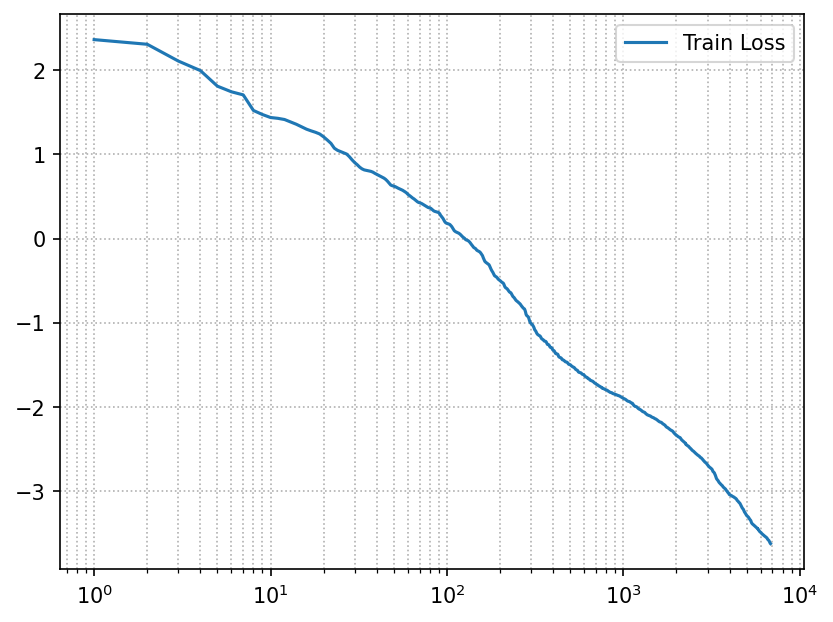

In [6]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

### Save and load the training hyperparameters

In [8]:
torch.save(pinn.approximate_solution.state_dict(), 'hyperparameters.pth')
pinn.approximate_solution.load_state_dict(torch.load("hyperparameters.pth"))

<All keys matched successfully>

ValueError: 'c' argument has 200000 elements, which is inconsistent with 'x' and 'y' with size 100000.

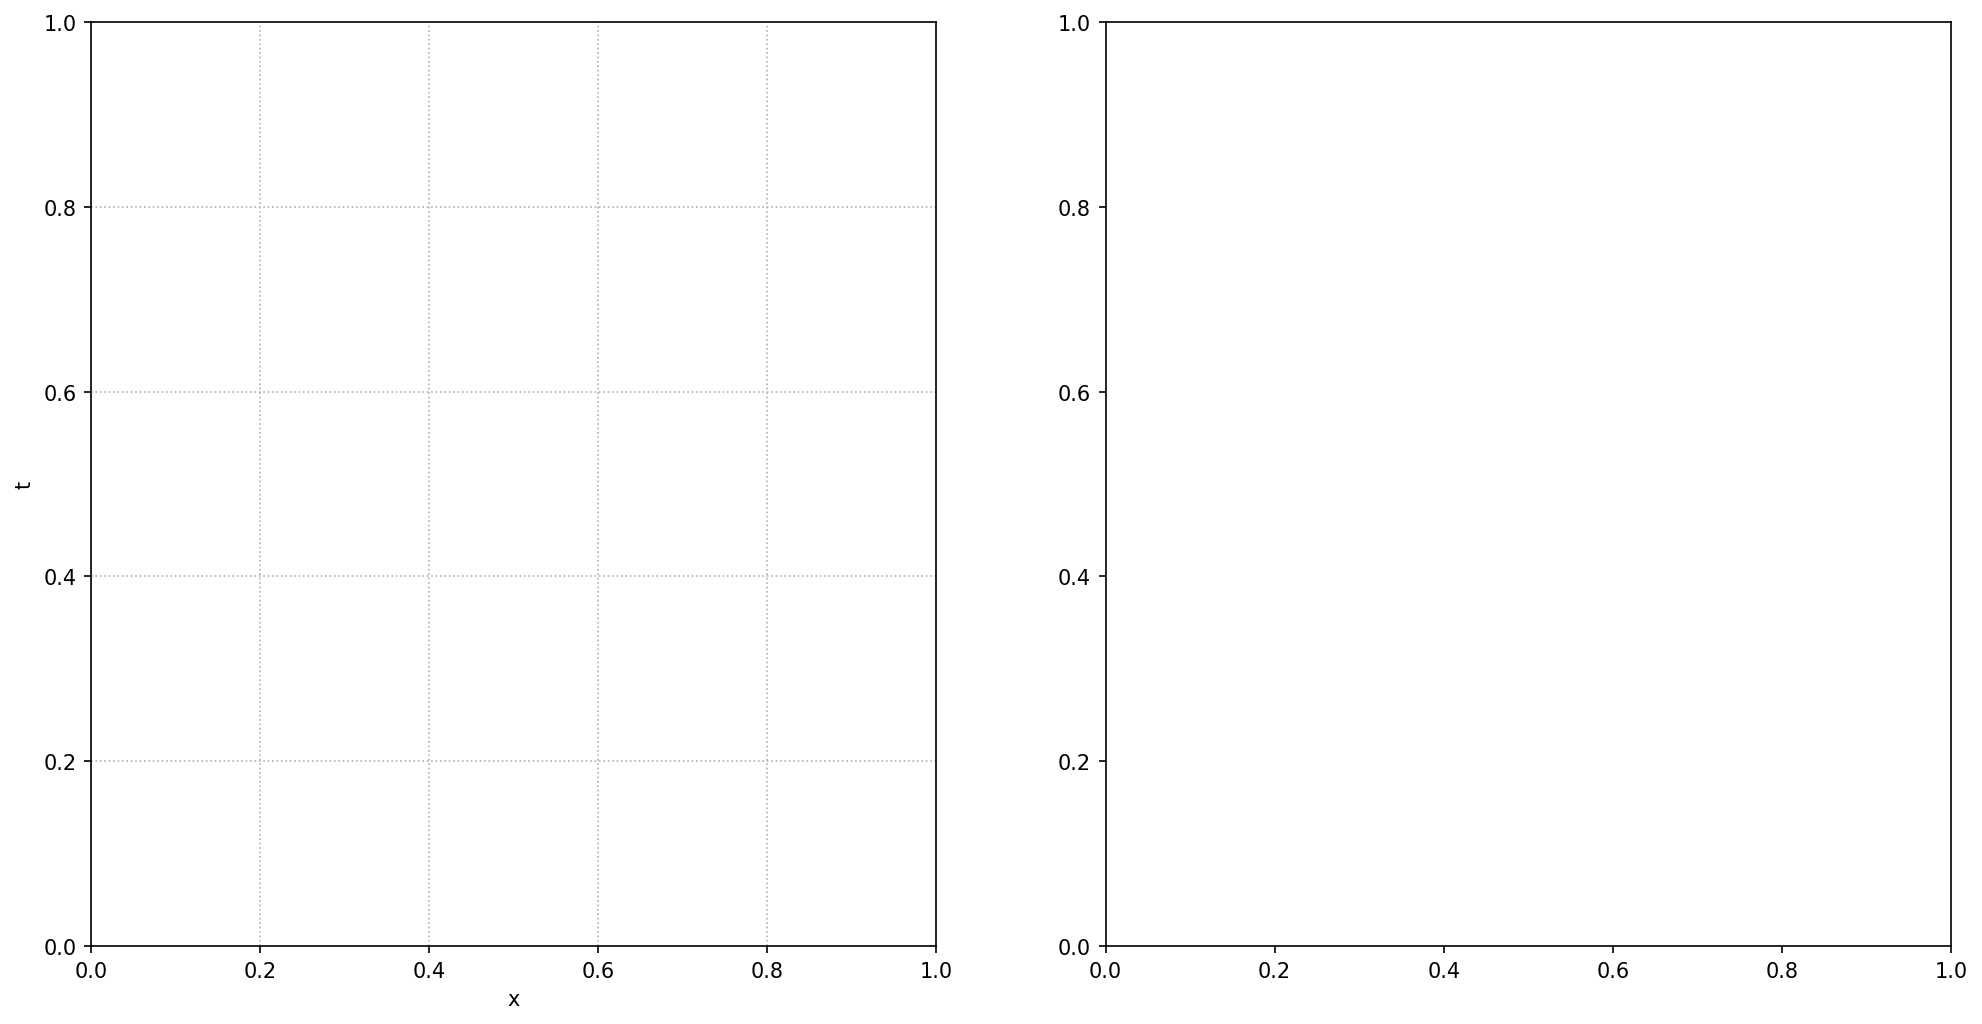

In [20]:
pinn.plotting()

#### Get the predictions on the test data

In [28]:
# test_data = pandas.loadtxt("Task1/TestingData.txt", delimiter=',')

test_data = pd.read_csv("Task1/TestingData.txt", delimiter=',')
display(test_data)

t_test = torch.tensor(test_data['t'].values, dtype=torch.float32).reshape(-1, 1)
x_test = torch.tensor(test_data['x'].values, dtype=torch.float32).reshape(-1, 1)

,t,x
0,0.624062,0.895
1,0.783512,0.778
2,0.398106,0.469
3,0.415906,0.948
4,0.949750,0.457
...,...,...
99995,0.811444,0.697
99996,0.498512,0.248
99997,0.718912,0.100
99998,0.953963,0.247


In [ ]:
for i in t_test:
    print(i)